In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from skimage.feature import greycomatrix, greycoprops, hog, greycomatrix
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# **Preprocess**

# Feature Engineering

In [ ]:
class FeatureExtractor:
    @staticmethod
    def mean_pixel_value(images):
        features = []
        for img in images:
            feature = np.mean(img)
            features.append(feature)
        return np.array(features)

    @staticmethod
    def std_pixel_value(images):
        features = []
        for img in images:
            feature = np.std(img)
            features.append(feature)
        return np.array(features)

    @staticmethod
    def edge_based_features(images):
        features = []
        for img in images:
            if len(img.shape) == 3:
                gray_img = rgb2gray(img)
            else:
                gray_img = img
            edge_sobel = sobel(gray_img)
            feature = np.mean(edge_sobel)
            features.append(feature)
        return np.array(features)

    @staticmethod
    def histogram_features(images):
        features = []
        for img in images:
            hist, _ = np.histogram(img.flatten(), bins=256, range=(0, 256))
            features.append(hist)
        return np.array(features)

    @staticmethod
    def texture_features(images):
        features = []
        for img in images:
            if len(img.shape) == 3:
                gray_img = rgb2gray(img)
            else:
                gray_img = img
            glcm = greycomatrix(gray_img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            contrast = greycoprops(glcm, 'contrast')[0, 0]
            energy = greycoprops(glcm, 'energy')[0, 0]
            features.append([contrast, energy])
        return np.array(features)

    @staticmethod
    def color_histogram_features(images):
        features = []
        for img in images:
            if len(img.shape) == 3:
                hist_red, _ = np.histogram(img[:, :, 0].flatten(), bins=256, range=(0, 256))
                hist_green, _ = np.histogram(img[:, :, 1].flatten(), bins=256, range=(0, 256))
                hist_blue, _ = np.histogram(img[:, :, 2].flatten(), bins=256, range=(0, 256))
                features.append(np.concatenate((hist_red, hist_green, hist_blue)))
            else:
                hist, _ = np.histogram(img.flatten(), bins=256, range=(0, 256))
                features.append(hist)
        return np.array(features)

    @staticmethod
    def texture_entropy(images):
        features = []
        for img in images:
            if len(img.shape) == 3:
                gray_img = rgb2gray(img)
            else:
                gray_img = img
            entropy = shannon_entropy(gray_img)
            features.append(entropy)
        return np.array(features)

# Resize And Greyscale

In [ ]:
def resize_and_convert_grayscale(images, target_size=(128, 128)):
    resized_images = []
    for img in images:
        pil_img = Image.fromarray(img).convert('L')
        resized_img = pil_img.resize(target_size, Image.ANTIALIAS)
        resized_images.append(np.array(resized_img))
    return resized_images

# Load and Resize

In [ ]:
def load_and_resize_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        images.append(np.array(img))
    return resize_and_convert_grayscale(images)

In [ ]:
defect_images = load_and_resize_images_from_folder('/content/drive/MyDrive/fabric-detections/Defect_images')
mask_images = load_and_resize_images_from_folder('/content/drive/MyDrive/fabric-detections/Mask_images')

no_defect_images_folders = [
    '2306881-210020u', '2306894-210033u', '2311517-195063u',
    '2311694-1930c7u', '2311694-2040n7u', '2311980-185026u', '2608691-202020u'
]

no_defect_images = []
for folder in no_defect_images_folders:
    images = load_and_resize_images_from_folder(f'/content/drive/MyDrive/fabric-detections/NODefect_images/{folder}')
    no_defect_images.extend(images)

<ipython-input-123-652907471cc5>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = pil_img.resize(target_size, Image.ANTIALIAS)


# Label Encoding

In [ ]:
X = np.concatenate((defect_images, mask_images, no_defect_images), axis=0)

defect_labels = np.ones(len(defect_images))
mask_labels = np.ones(len(mask_images))
no_defect_labels = np.zeros(len(no_defect_images))

y = np.concatenate((defect_labels, mask_labels, no_defect_labels))

# Future Extraction

In [ ]:
mean_pixel_values = FeatureExtractor.mean_pixel_value(X)
std_pixel_values = FeatureExtractor.std_pixel_value(X)
histogram_feats = FeatureExtractor.histogram_features(X)
edge_feats = FeatureExtractor.edge_based_features(X)
texture_feats = FeatureExtractor.texture_features(X)
color_hist_feats = FeatureExtractor.color_histogram_features(X)
entropy_feats = FeatureExtractor.texture_entropy(X)

In [ ]:
X_features = np.concatenate((
    mean_pixel_values[:, np.newaxis],
    std_pixel_values[:, np.newaxis],
    histogram_feats,
    edge_feats[:, np.newaxis],
    texture_feats,
    color_hist_feats,
    entropy_feats[:, np.newaxis],
), axis=1)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2, random_state=42)

# Resample Data SMOTE Analysis

In [ ]:
smote = SMOTE(random_state=57)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Model Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, label_encoder, title):
    y_pred = model.predict(X_test)
    y_test_original = label_encoder.inverse_transform(y_test)
    y_pred_original = label_encoder.inverse_transform(y_pred)

    target_names = ['No Defect', 'Defect']
    print(classification_report(y_test_original, y_pred_original, target_names=target_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot Graphics

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

def plot_pr_curve(recall, precision, average_precision, title):
    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color='green', where='post', label='Precision-Recall curve (AP = %0.2f)' % average_precision)
    plt.fill_between(recall, precision, alpha=0.2, color='green', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

# **Model Training**

# SVM Model

              precision    recall  f1-score   support

   No Defect       0.52      1.00      0.68        28
      Defect       1.00      0.40      0.57        43

    accuracy                           0.63        71
   macro avg       0.76      0.70      0.62        71
weighted avg       0.81      0.63      0.61        71



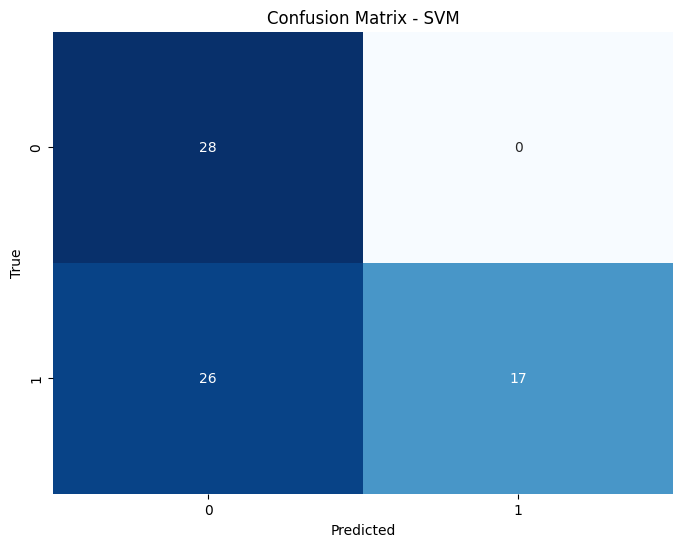

In [ ]:
svm = SVC(kernel='rbf', random_state=42)

svm.fit(X_train_resampled, y_train_resampled)

evaluate_model(svm, X_test, y_test, label_encoder, 'SVM')

# SVM Model Graph

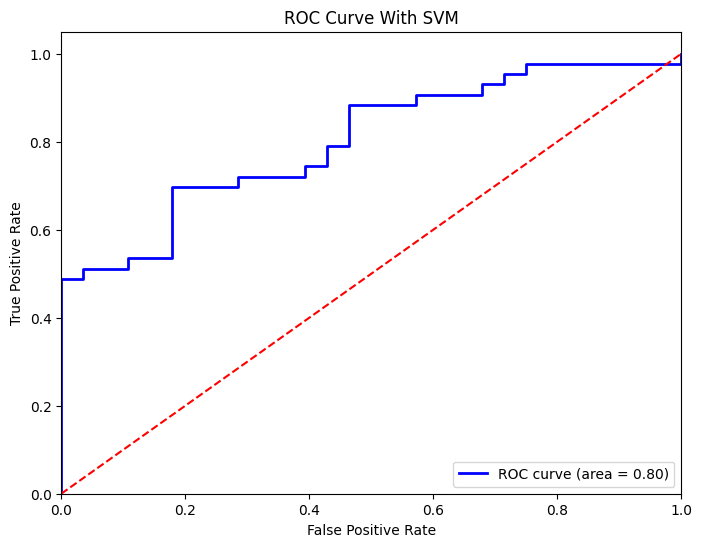

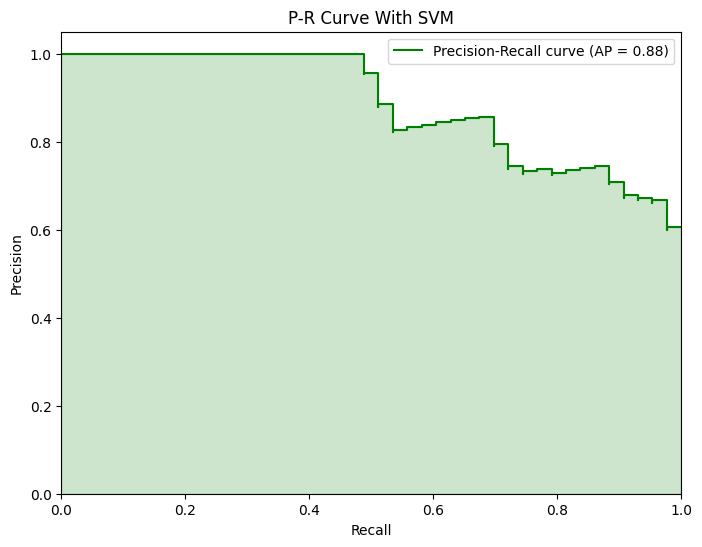

In [ ]:
y_scores_svm = svm.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_scores_svm)
average_precision_svm = average_precision_score(y_test, y_scores_svm)

plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'ROC Curve With SVM')
plot_pr_curve(recall_svm, precision_svm, average_precision_svm, 'P-R Curve With SVM')

# Adaboost Model

              precision    recall  f1-score   support

   No Defect       0.77      0.82      0.79        28
      Defect       0.88      0.84      0.86        43

    accuracy                           0.83        71
   macro avg       0.82      0.83      0.83        71
weighted avg       0.83      0.83      0.83        71



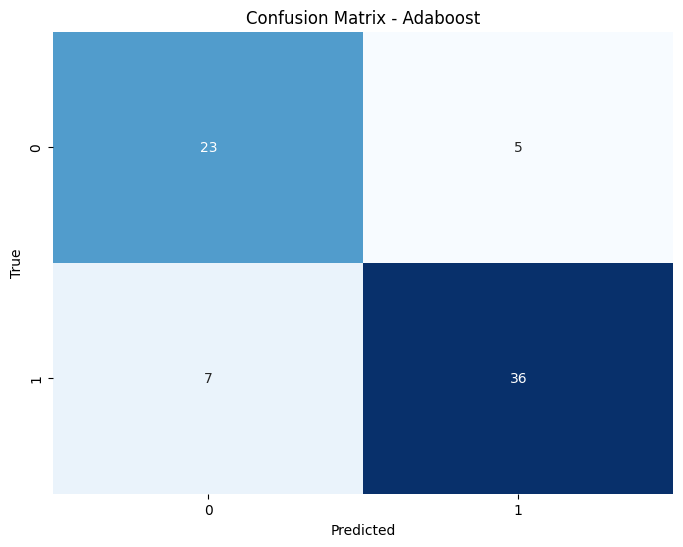

In [ ]:
adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)

adaboost.fit(X_train_resampled, y_train_resampled)

evaluate_model(adaboost, X_test, y_test, label_encoder, 'Adaboost')

# Adaboost Model Graph

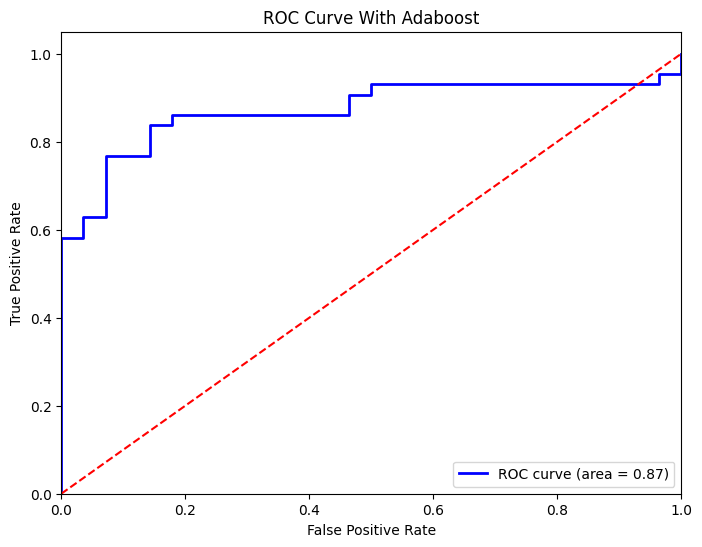

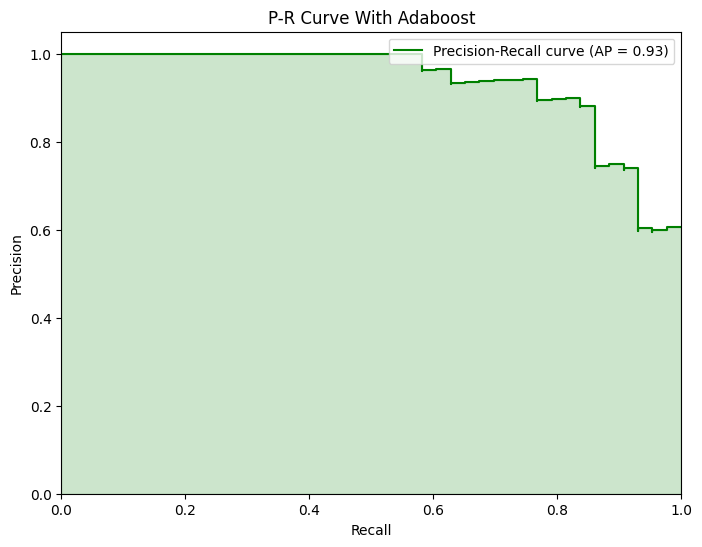

In [ ]:
y_scores_adaboost = adaboost.predict_proba(X_test)[:, 1]
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test, y_scores_adaboost)
roc_auc_adaboost = auc(fpr_adaboost, tpr_adaboost)

precision_adaboost, recall_adaboost, _ = precision_recall_curve(y_test, y_scores_adaboost)
average_precision_adaboost = average_precision_score(y_test, y_scores_adaboost)

plot_roc_curve(fpr_adaboost, tpr_adaboost, roc_auc_adaboost, 'ROC Curve With Adaboost')
plot_pr_curve(recall_adaboost, precision_adaboost, average_precision_adaboost, 'P-R Curve With Adaboost')

# XGBoost Model

              precision    recall  f1-score   support

   No Defect       0.76      0.89      0.82        28
      Defect       0.92      0.81      0.86        43

    accuracy                           0.85        71
   macro avg       0.84      0.85      0.84        71
weighted avg       0.86      0.85      0.85        71



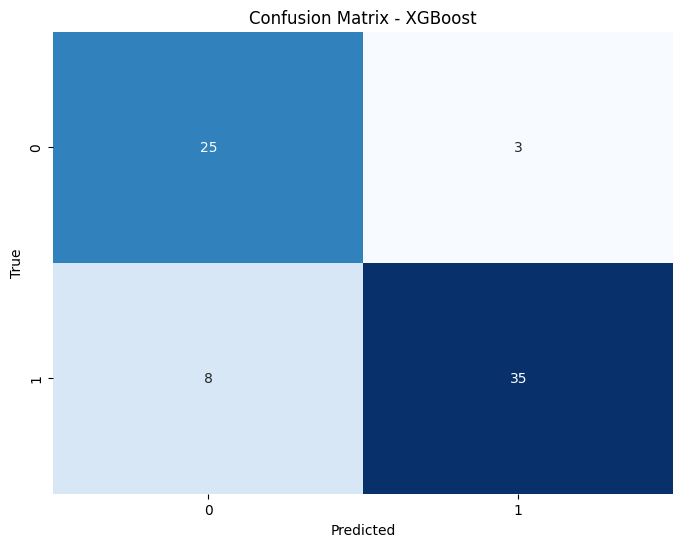

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

xgb_model.fit(X_train_resampled, y_train_resampled)

evaluate_model(xgb_model, X_test, y_test, label_encoder, 'XGBoost')

# XGBoost Model Graph

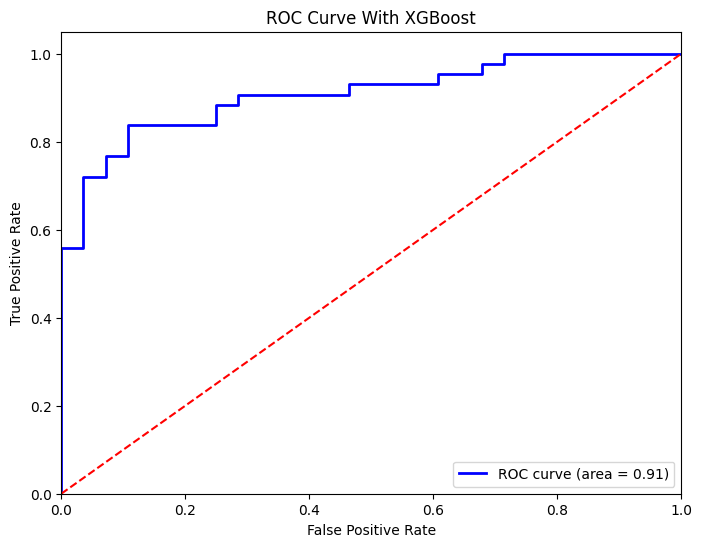

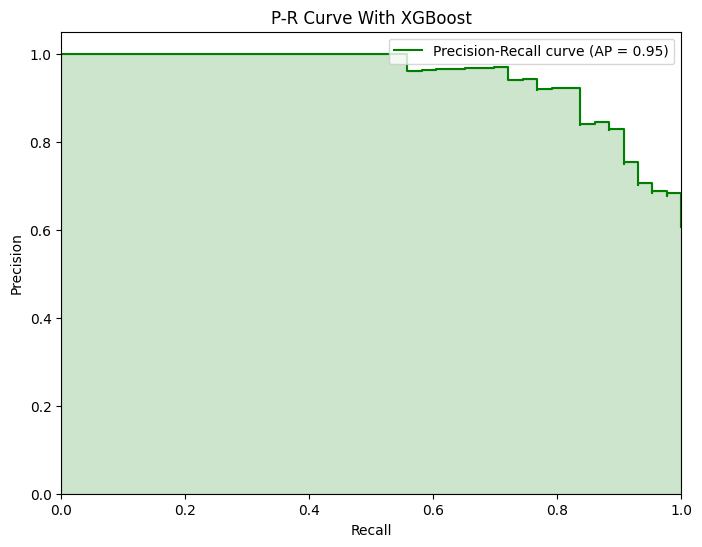

In [ ]:
y_scores_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_scores_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_scores_xgb)
average_precision_xgb = average_precision_score(y_test, y_scores_xgb)

plot_roc_curve(fpr_xgb, tpr_xgb, roc_auc_xgb, 'ROC Curve With XGBoost')
plot_pr_curve(recall_xgb, precision_xgb, average_precision_xgb, 'P-R Curve With XGBoost')

# Random Forest Model

              precision    recall  f1-score   support

   No Defect       0.77      0.86      0.81        28
      Defect       0.90      0.84      0.87        43

    accuracy                           0.85        71
   macro avg       0.84      0.85      0.84        71
weighted avg       0.85      0.85      0.85        71



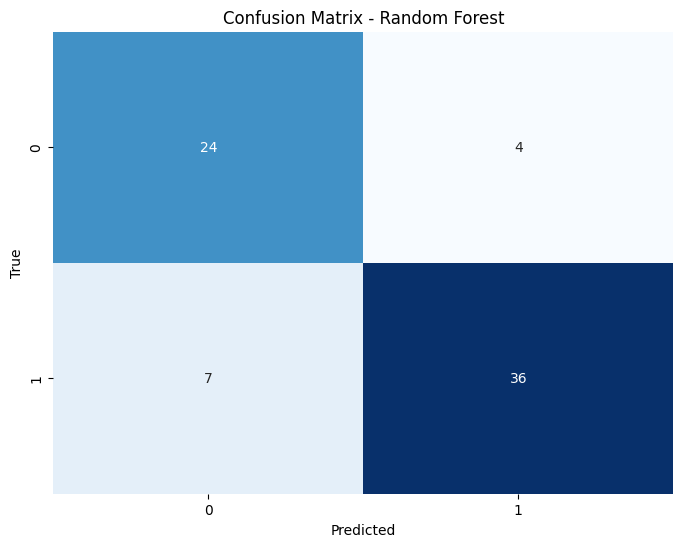

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

rf_classifier.fit(X_train_resampled, y_train_resampled)

evaluate_model(rf_classifier, X_test, y_test, label_encoder, 'Random Forest')

# Random Forest Model Graph

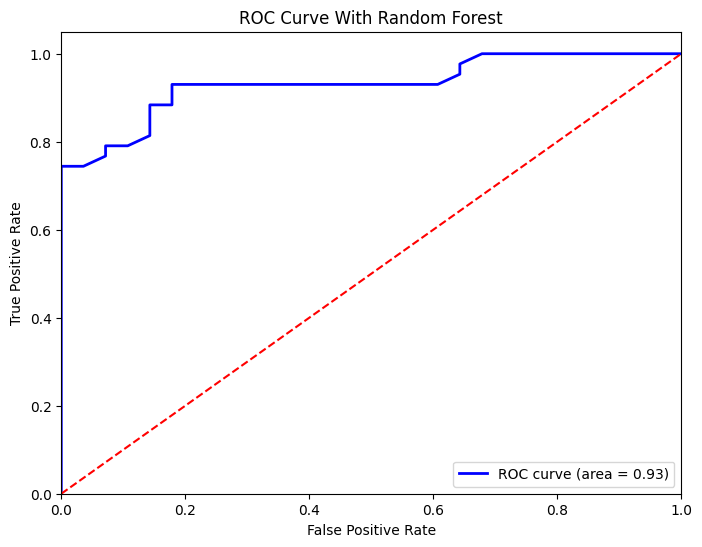

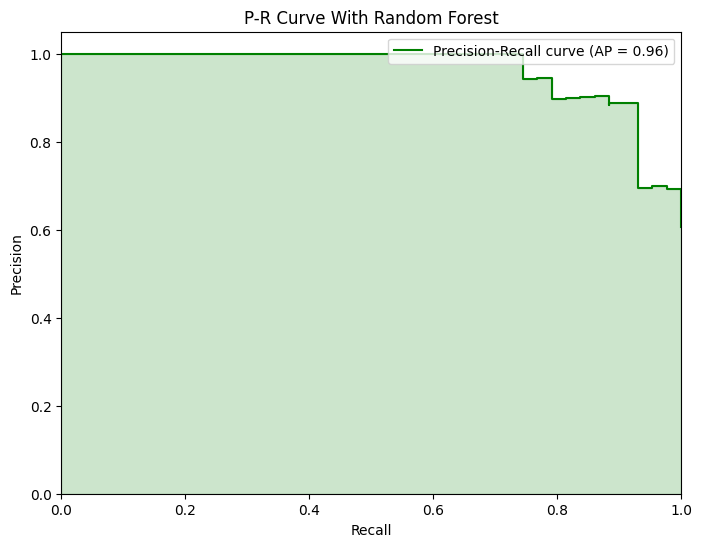

In [ ]:
y_scores_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)
average_precision_rf = average_precision_score(y_test, y_scores_rf)

plot_roc_curve(fpr_rf, tpr_rf, roc_auc_rf, 'ROC Curve With Random Forest')
plot_pr_curve(recall_rf, precision_rf, average_precision_rf, 'P-R Curve With Random Forest')

# MLP Model

              precision    recall  f1-score   support

   No Defect       0.73      0.86      0.79        28
      Defect       0.89      0.79      0.84        43

    accuracy                           0.82        71
   macro avg       0.81      0.82      0.81        71
weighted avg       0.83      0.82      0.82        71



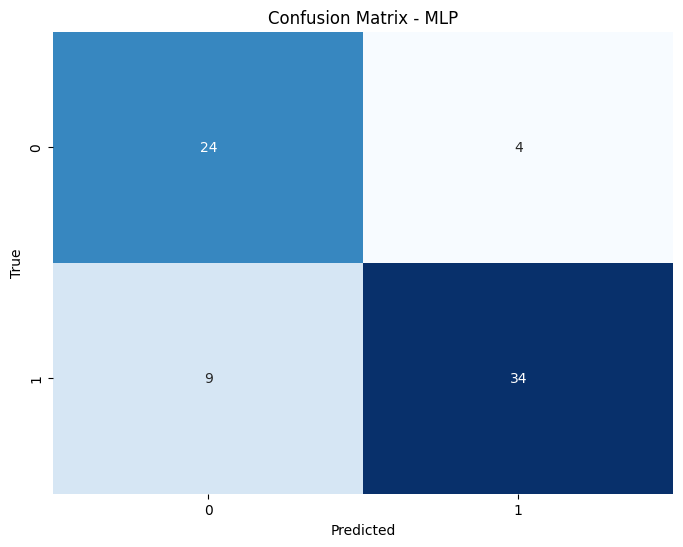

In [ ]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, activation='relu', random_state=42)

X_train_resampled_mlp, y_train_resampled_mlp = smote.fit_resample(X_train, y_train)

mlp_model.fit(X_train_resampled_mlp, y_train_resampled_mlp)

evaluate_model(mlp_model, X_test, y_test, label_encoder, 'MLP')

# MLP Model Graph

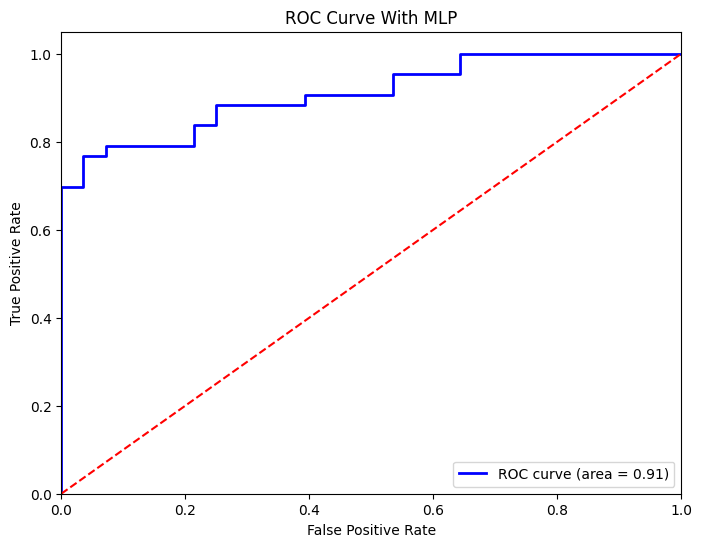

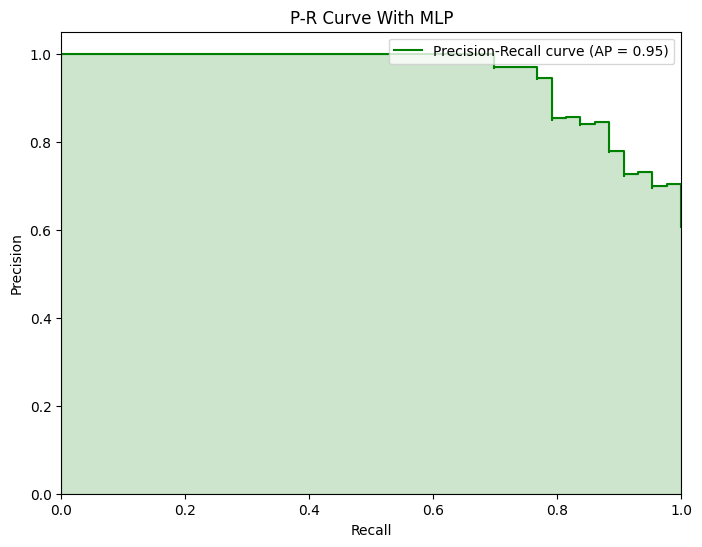

In [ ]:
y_scores_mlp = mlp_model.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_scores_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

precision_mlp, recall_mlp, _ = precision_recall_curve(y_test, y_scores_mlp)
average_precision_mlp = average_precision_score(y_test, y_scores_mlp)

plot_roc_curve(fpr_mlp, tpr_mlp, roc_auc_mlp, 'ROC Curve With MLP')
plot_pr_curve(recall_mlp, precision_mlp, average_precision_mlp, 'P-R Curve With MLP')

# CNN Evaluate

In [ ]:
def evaluate_model_cnn(model, X_test, y_test, label_encoder, title):
    y_pred = model.predict(X_test).ravel()
    y_pred_binary = (y_pred > 0.5).astype(int)

    y_test_binary = (y_test > 0.5).astype(int)

    y_test_original = label_encoder.inverse_transform(y_test_binary)
    y_pred_original = label_encoder.inverse_transform(y_pred_binary)

    target_names = ['No Defect', 'Defect']
    print(classification_report(y_test_original, y_pred_original, target_names=target_names))

    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc, f'{title} - ROC Curve')

    precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred)
    average_precision = average_precision_score(y_test_binary, y_pred)
    plot_pr_curve(recall, precision, average_precision, f'{title} - Precision-Recall Curve')


# CNN Model

Epoch 1/100
18/18 [==============================] - 4s 36ms/step - loss: 0.8552 - accuracy: 0.6360 - val_loss: 0.9885 - val_accuracy: 0.6197
Epoch 2/100
18/18 [==============================] - 0s 23ms/step - loss: 0.6852 - accuracy: 0.6502 - val_loss: 0.6041 - val_accuracy: 0.5775
Epoch 3/100
18/18 [==============================] - 0s 22ms/step - loss: 0.6286 - accuracy: 0.6890 - val_loss: 0.6125 - val_accuracy: 0.6056
Epoch 4/100
18/18 [==============================] - 0s 23ms/step - loss: 0.6302 - accuracy: 0.6714 - val_loss: 0.5463 - val_accuracy: 0.6197
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 0.6606 - accuracy: 0.6784 - val_loss: 0.5639 - val_accuracy: 0.6338
Epoch 6/100
18/18 [==============================] - 0s 23ms/step - loss: 0.5447 - accuracy: 0.6855 - val_loss: 0.5416 - val_accuracy: 0.6338
Epoch 7/100
18/18 [==============================] - 0s 23ms/step - loss: 0.5633 - accuracy: 0.6961 - val_loss: 0.5337 - val_accuracy: 0.6197
Epoch 

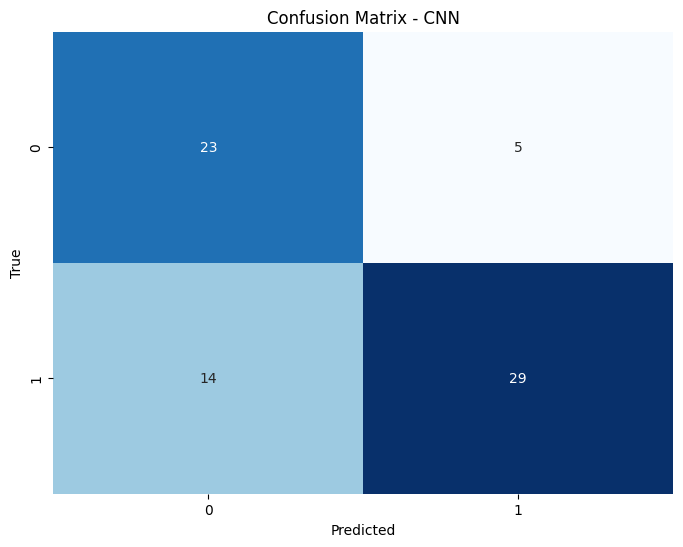

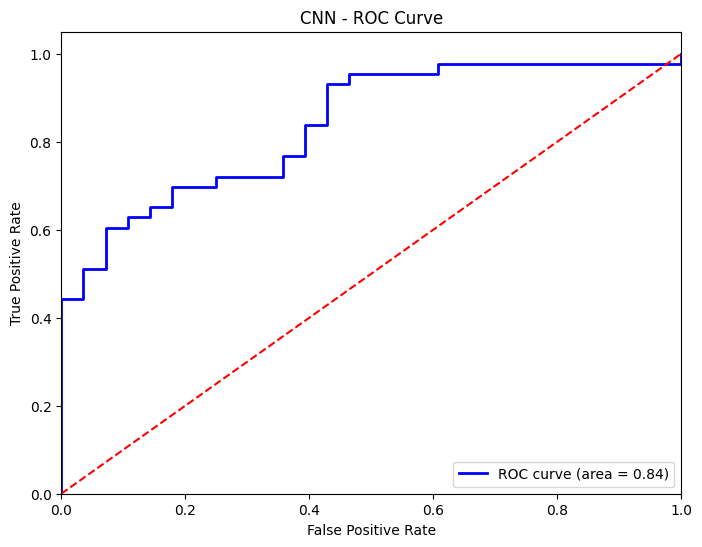

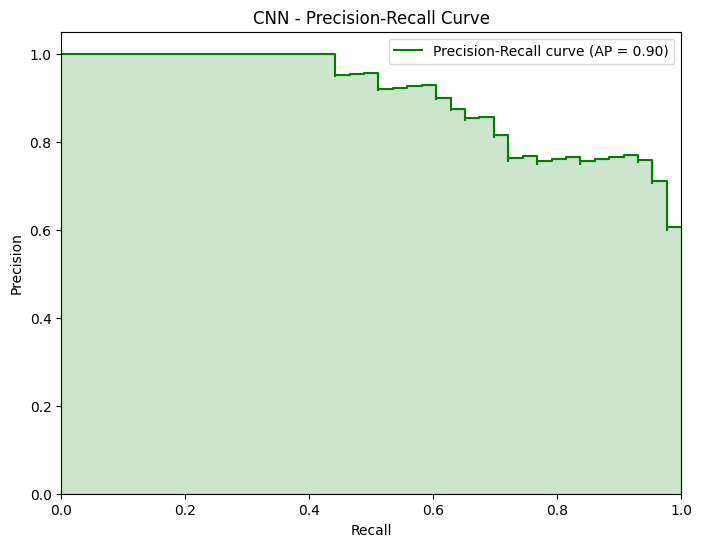

In [ ]:
def create_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    return model

X_cnn = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_encoded, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

cnn_model_augmented = create_cnn_model(input_shape_cnn)

custom_optimizer = Adam(learning_rate=0.001)
cnn_model_augmented.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_model_augmented.fit(datagen.flow(X_train_cnn, y_train_cnn, batch_size=16),
                                  epochs=100,
                                  validation_data=(X_test_cnn, y_test_cnn),
                                  callbacks=[early_stopping])

evaluate_model_cnn(cnn_model_augmented, X_test_cnn, y_test_cnn, label_encoder, 'CNN')